In [1]:
import sys
sys.path.append("../")

import yaml
import matplotlib.pyplot as plt
import cattrs
from typing import List
#from mixture_optimization.datamodels.trial_tracking_config import Experiment, ValResult, Dict
from mixture_optimization.datamodels.trial_tracking_config import Experiment, ValResult, Dict

In [2]:
def plot_visualizations(experiment, start_teratrions=None):
    weights1 = []
    res1 = []
    res2 = []
    res = []

    # preprocessing
    trial0 = experiment.trials[0]
    assert len(trial0.val_results.keys()) == 2
    key1 = list(trial0.val_results.keys())[0]
    key2 = list(trial0.val_results.keys())[1]

    for trial in experiment.trials:
        if trial.val_results is None:
            print(f"Skipping trial {trial.idx} as it has no val results")
            continue
        

        w1 = trial.true_mixing_weights[key1]
        w2 = trial.true_mixing_weights[key2]

        
        res1.append(trial.val_results[key1].perplexity)
        res2.append(trial.val_results[key2].perplexity)
        

        weights1.append(w1)
        res.append(trial.weighted_val_perplexity)

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    # plot weighte val perpleixty over time
    axs[0].plot(res, '-o')
    axs[0].set_xlabel('Run')
    axs[0].set_ylabel('Weighted Val Perplexity')
    if start_teratrions:
        axs[0].axvline(x=start_teratrions - 1, color='r', linestyle='--')

    # plot cc weights over time
    axs[1].plot(weights1, '-o')
    axs[1].set_xlabel('Run')
    axs[1].set_ylabel(f'{key1} Mixing Weight')
    axs[1].set_ylim([0, 1])
    if start_teratrions:
        axs[1].axvline(x=start_teratrions - 1, color='r', linestyle='--')

    # create 3 subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

    # reorder results according to weights1
    res = [x for _, x in sorted(zip(weights1, res), key=lambda pair: pair[0])]
    res1 = [x for _, x in sorted(zip(weights1, res1), key=lambda pair: pair[0])]
    res2 = [x for _, x in sorted(zip(weights1, res2), key=lambda pair: pair[0])]
    weights1 = sorted(weights1)

    # plot 1
    axs[0].plot(weights1, res,'-o')
    axs[0].set_xlabel(f'Mixing Weight {key1}')
    axs[0].set_ylabel('Weighted Val Perplexity')

    # plot 2
    axs[1].plot(weights1, res1,'-o')
    axs[1].set_xlabel(f'Mixing Weight {key1}')
    axs[1].set_ylabel(f'{key1} Perplexity')

    # plot 3
    axs[2].plot(weights1, res2, '-o')
    axs[2].set_xlabel(f'Mixing Weight {key1}')
    axs[2].set_ylabel(f'{key2} Perplexity')

    best_perplexity = min(res)
    best_idx = res.index(best_perplexity)

    print(f"Best perplexity: {best_perplexity} at mixing weight: {weights1[best_idx]}")


    

    return (weights1, res)


In [3]:
def read_experiments(experimnt_history):
    with open(experimnt_history, 'r') as f:
        obj = yaml.safe_load(f)
    
    experiments = cattrs.structure(obj, List[Experiment])
    return experiments


def get_experiment_result(experiment: Experiment):
    val_results: List[Dict[str, ValResult]] = []
    domain_weights: List[Dict[str, float]] = []
    weighted_perplexity = []
    for i, trial in enumerate(experiment.trials):
        if not trial.weighted_val_perplexity:
            print(f"Trial {i} did not finish yet. Breaking")
            continue
        val_results.append(trial.val_results)
        weighted_perplexity.append(trial.weighted_val_perplexity)
        domain_weights.append(trial.true_mixing_weights)
    return val_results, weighted_perplexity, domain_weights

def plot_weighted_val_perplexity(weighted_val_perplexities: List[float], no_initial_runs: int = 0):
    plt.plot(weighted_val_perplexities)
    plt.scatter(range(len(weighted_val_perplexities)), weighted_val_perplexities)
    plt.axvline(x=no_initial_runs - 1, color='r', linestyle='--')
    plt.xlabel('Run')
    plt.ylabel('Weighted Val Perplexity')
    plt.title('Weighted Val Perplexity')

def plot_domain_perplexities(val_results: List[Dict[str, ValResult]], no_initial_runs: int = 0):
    max_plots_per_row = 4
    domains = val_results[0].keys()
    num_plots = len(domains)
    num_rows = num_plots // max_plots_per_row + 1
    num_cols = min(num_plots, max_plots_per_row)
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))
    fig.suptitle('Domain Perplexities')
    axs = axs.flatten()

    for i, domain in enumerate(domains):
        domain_perplexities = [val_result[domain].perplexity for val_result in val_results]
        axs[i].plot(domain_perplexities)
        axs[i].set_title(domain)
        axs[i].set_xlabel('Run')
        axs[i].set_ylabel('Perplexity')
        axs[i].axvline(x=no_initial_runs - 1, color='r', linestyle='--')
        axs[i].scatter(range(len(domain_perplexities)), domain_perplexities)
    plt.tight_layout()  

def plot_mixing_weights(mixing_weights: List[Dict[str, float]], no_initial_runs: int = 0):
    max_plots_per_row = 4
    domains = mixing_weights[0].keys()
    num_plots = len(domains)
    num_rows = num_plots // max_plots_per_row + 1
    num_cols = min(num_plots, max_plots_per_row)
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))
    fig.suptitle('Mixing Weights')
    axs = axs.flatten()

    for i, domain in enumerate(domains):
        mix_w = [weight[domain] for weight in mixing_weights]
        axs[i].plot(mix_w)
        axs[i].set_title(domain)
        axs[i].set_xlabel('Run')
        axs[i].set_ylabel('Mixing Weight')
        axs[i].legend()
        axs[i].axvline(x=no_initial_runs - 1, color='r', linestyle='--')
        axs[i].scatter(range(len(mix_w)), mix_w)
    plt.tight_layout()  

In [4]:
results = []

Best perplexity: 4.406554162502289 at mixing weight: 0.5281012493068468


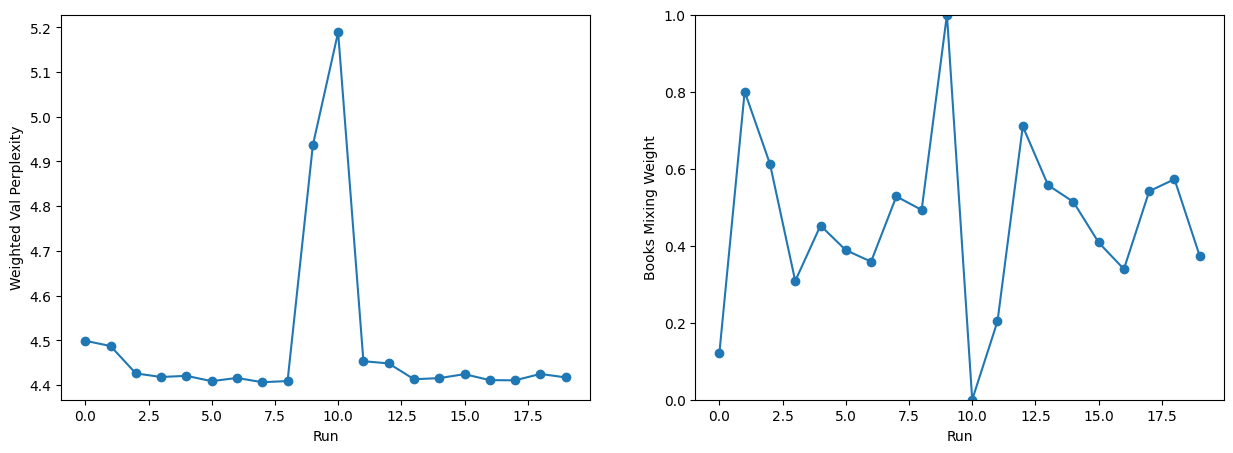

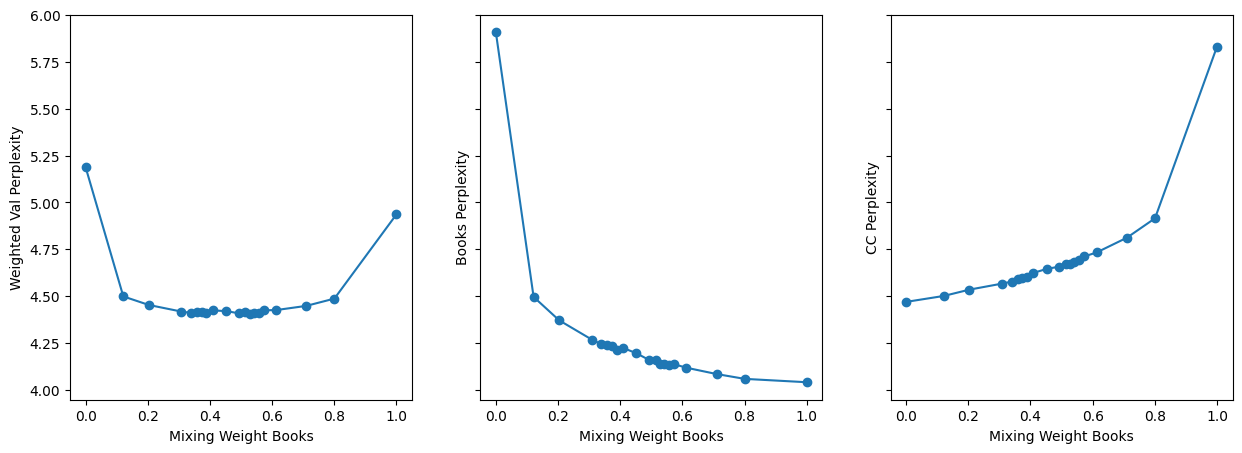

In [5]:
path = "/root/code/mixture_optimization/logs/lin_interp_books_cc_0/experiment_history.yaml"
path = "/root/code/mixture_optimization/logs/bayesian-two-sources_0/experiment_history.yaml"
experiments = read_experiments(path)
experiment = experiments[0]
res = plot_visualizations(experiment)
results.append((res, "Books CC"))

Skipping trial 25 as it has no val results
Best perplexity: 4.40161557495594 at mixing weight: 0.46379565297756903


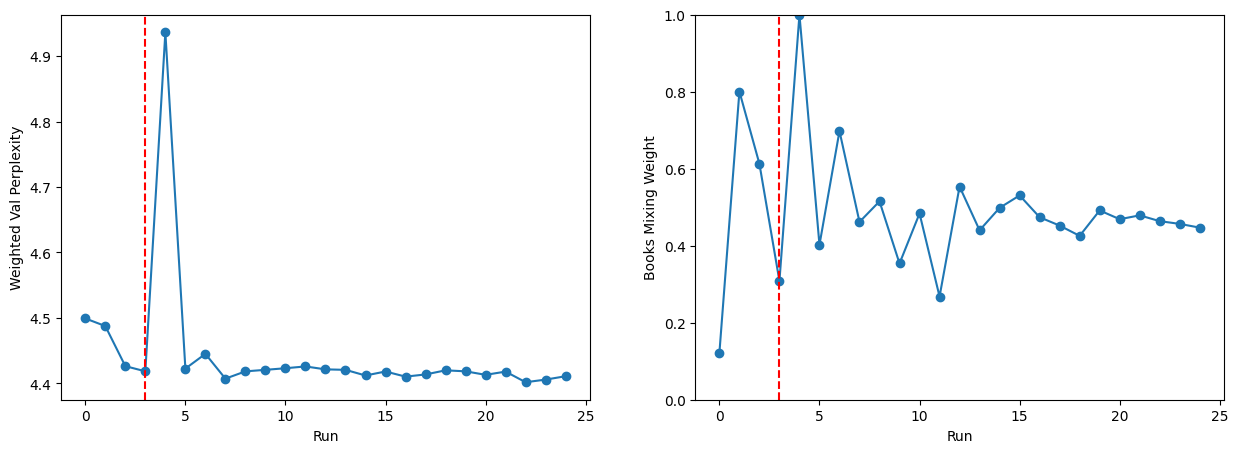

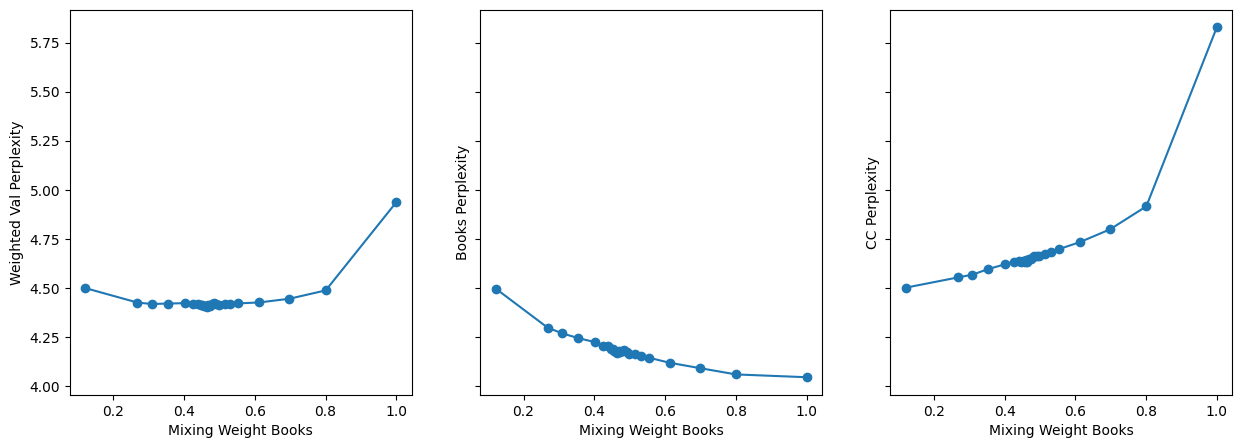

In [6]:
path2 = "/root/code/mixture_optimization/logs/turbo-two-sources_1/experiment_history.yaml"
experiments2 = read_experiments(path2)
experiment2 = experiments2[0]
res = plot_visualizations(experiment2, 4)
results.append((res, "Books CC Turbo"))

Best perplexity: 4.406554162502289 at mixing weight: 0.5281012493068468


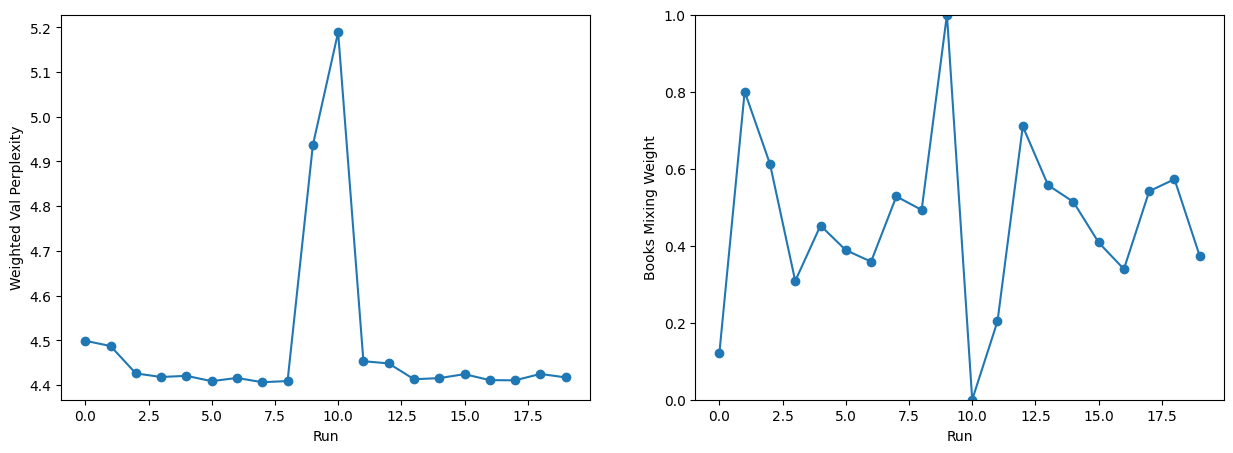

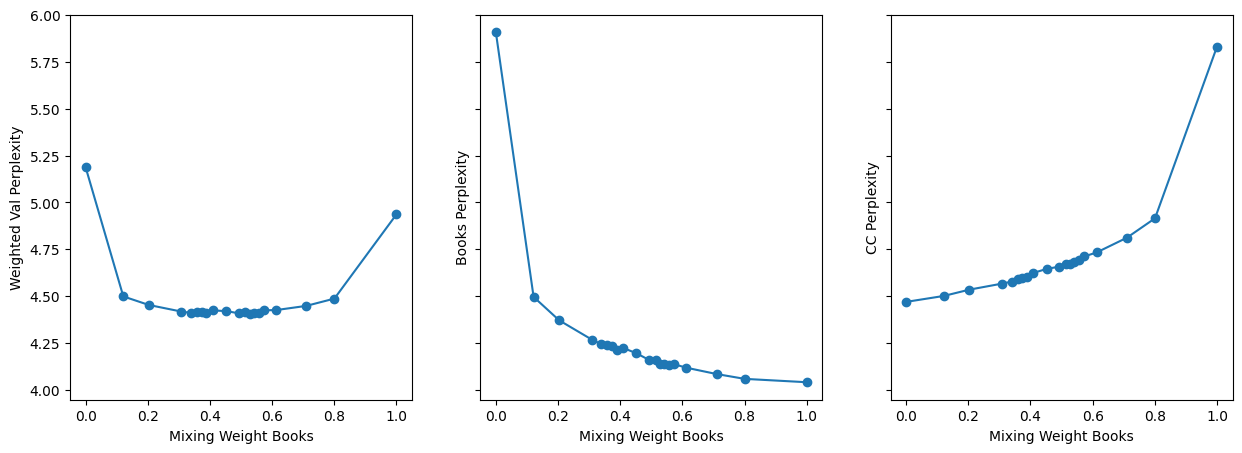

In [7]:
path3 = "/root/code/mixture_optimization/logs/bayesian-two-sources_0/experiment_history.yaml"
experiments3 = read_experiments(path3)
experiment3 = experiments3[0]
res = plot_visualizations(experiment3)
results.append((res, "Books CC Bayesian"))

Best perplexity: 3.7546218931674957 at mixing weight: 0.4286273443870617


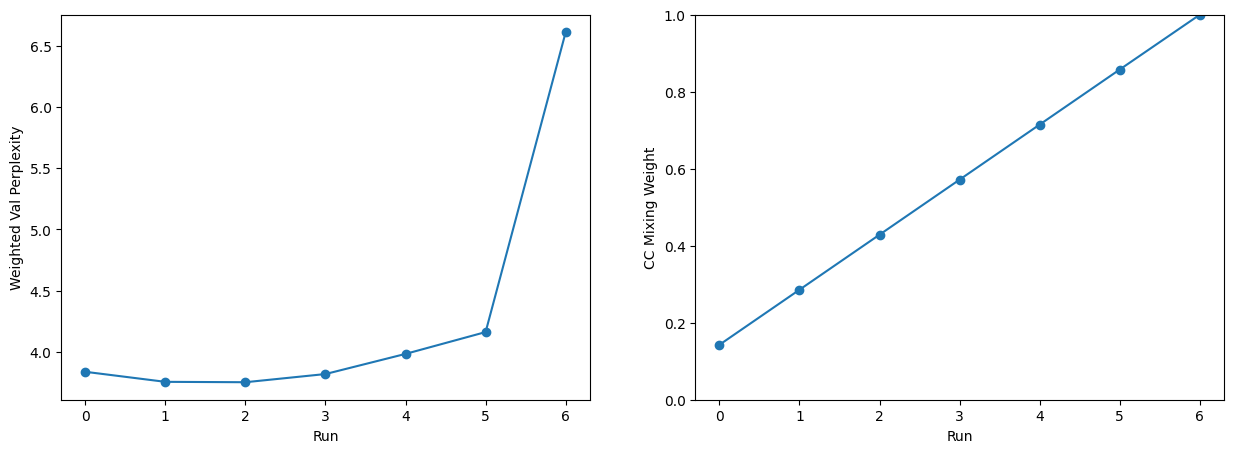

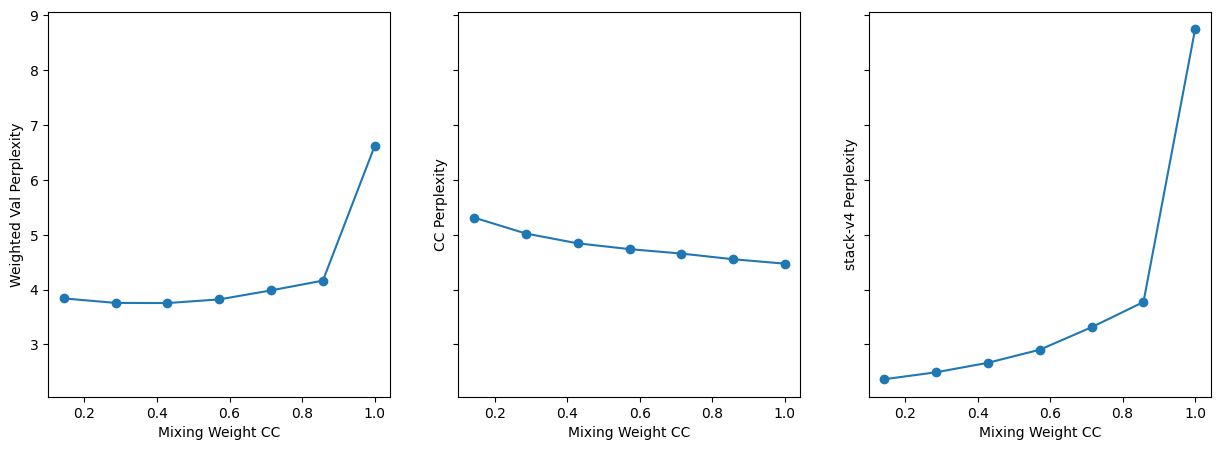

In [8]:
path = "/root/code/mixture_optimization/logs/lin_interp_cc_stack_0/experiment_history.yaml"
experiments = read_experiments(path)
experiment = experiments[0]
res = plot_visualizations(experiment)
results.append((res, "Stack CC"))

Best perplexity: 4.615514472126961 at mixing weight: 0.5713602261607046


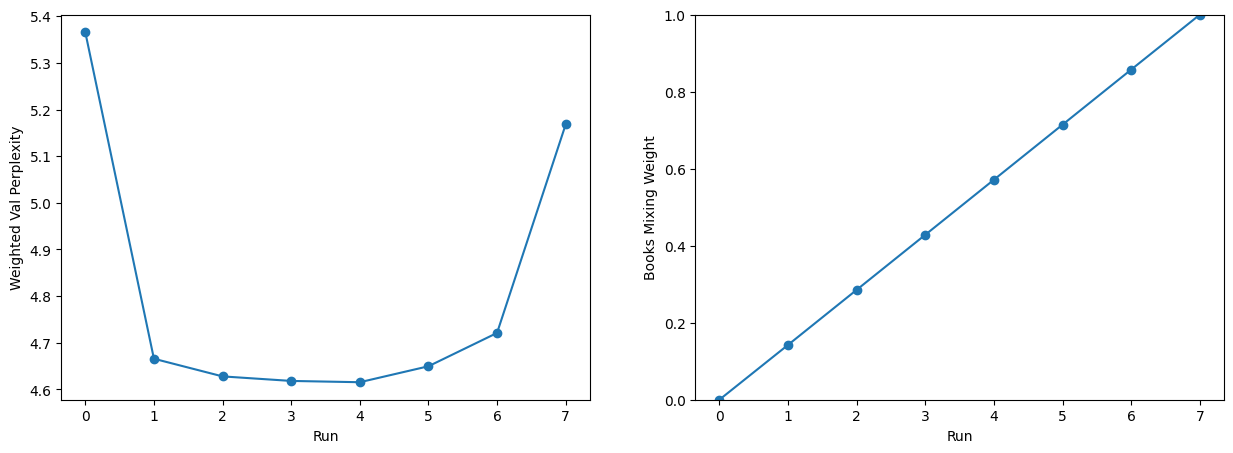

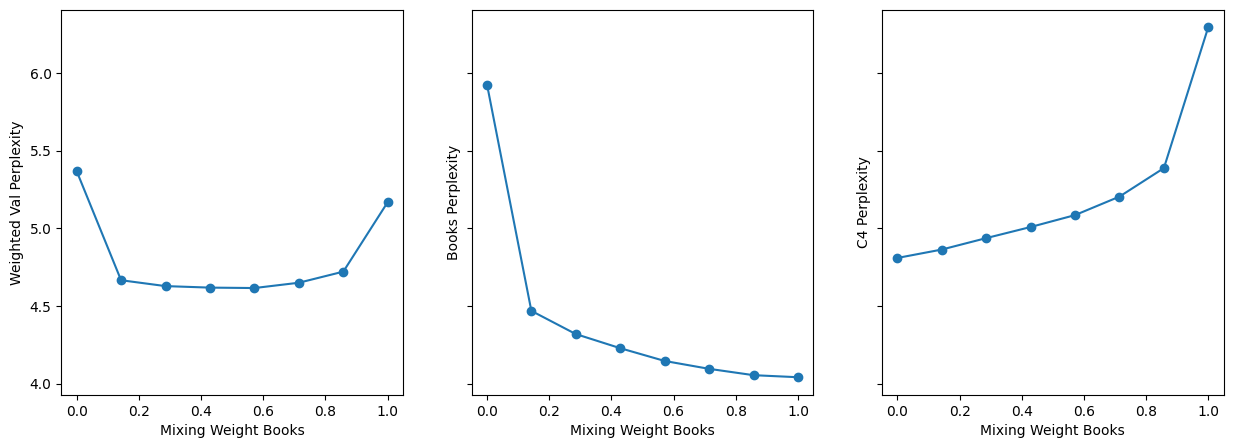

In [9]:
path = "/root/code/mixture_optimization/logs/lin_interp_books_c4_0/experiment_history.yaml"
experiments = read_experiments(path)
experiment = experiments[0]
res = plot_visualizations(experiment)
results.append((res, "Books C4"))

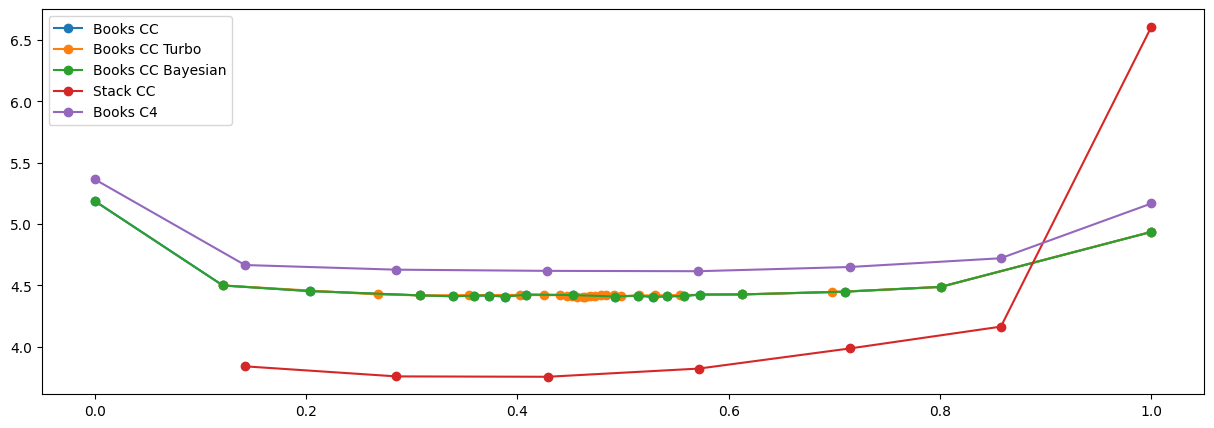

In [10]:
# plot all results
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
for (weights, res), name in results:
    axs.plot(weights, res, '-o', label=name)

plt.legend()

# Turbo Books C4

Best perplexity: 4.601403824985027 at mixing weight: 0.4852479069261716


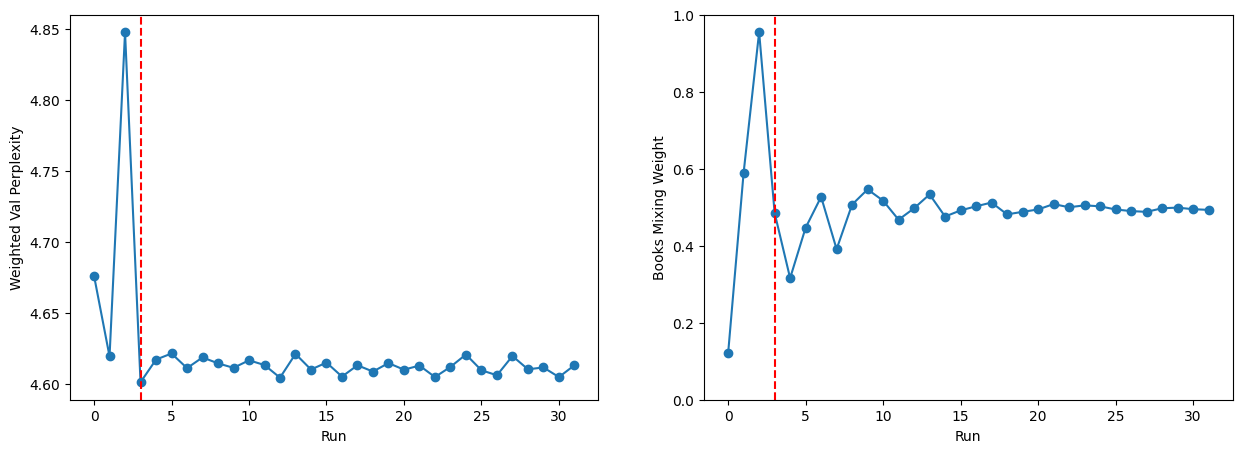

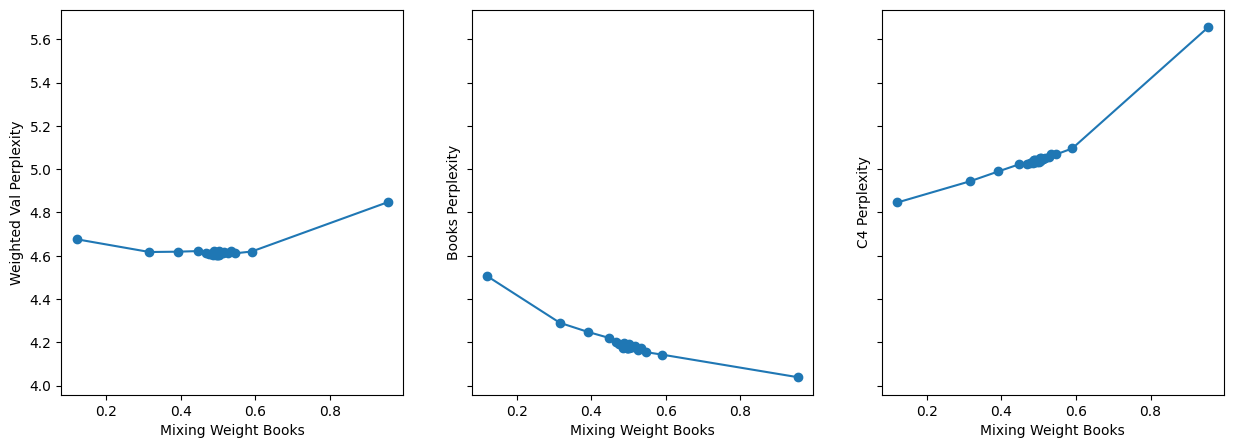

In [11]:
path = "/root/code/mixture_optimization/logs/turbo-two-sources-books-c4_1/experiment_history.yaml"
experiments = read_experiments(path)
experiment = experiments[0]

res = plot_visualizations(experiment, 4)